In [1]:
import numpy as np
from hottbox.core import Tensor
import yfinance as yf
import alphalens
import pandas as pd
from hottbox.pdtools import tensor_to_pd, pd_to_tensor
from hottbox.utils.generation import residual_tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error, mse, rmse, mape
from hottbox.rank import rank_estimation as re
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-20", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-20", end="2019-05-21")

[*********************100%***********************]  20 of 20 completed


In [3]:
returns = pan["Adj Close"].apply(np.log).diff(1)
returns = returns.stack()
returns.index = returns.index.set_names(['date', 'asset'])
returns = returns.unstack()
# returns.index = returns.index.tz_localize('UTC')
returns = returns.stack()
returns

date        asset
2011-05-20  AAPL    -0.015716
            ADBE    -0.002828
            AMAT    -0.016890
            AMD     -0.002318
            AMZN    -0.000755
                       ...   
2019-05-20  TSLA    -0.027236
            TXN     -0.019479
            V       -0.003786
            VZ       0.015714
            XLNX    -0.036255
Length: 40240, dtype: float64

In [4]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-21", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-21", end="2019-05-21")

vol = pan["Volume"]
vol = vol.stack()
vol.index = vol.index.set_names(['date', 'asset'])
vol = vol.unstack()
vol = vol.stack()
vol

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     337968400
            ADBE       3246700
            AMAT      17189500
            AMD       16694300
            AMZN       3381000
                       ...    
2019-05-20  TSLA     102631000
            TXN        7519900
            V          4747400
            VZ        20910600
            XLNX      10459300
Length: 40240, dtype: int64

In [5]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-14", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-14", end="2019-05-21")

predictive_factor = pan['Open']
predictive_factor = -predictive_factor.pct_change(5)

predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

pricing = pan['Open'].iloc[1:]
pricing.index = pricing.index.tz_localize('UTC')

predictive_factor = predictive_factor.unstack()
# factor.index = factor.index.tz_localize('UTC')
predictive_factor = predictive_factor.stack()

predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     0.017647
            ADBE     0.008112
            AMAT     0.050532
            AMD      0.038117
            AMZN     0.037676
                       ...   
2019-05-20  TSLA     0.125900
            TXN      0.055693
            V       -0.039188
            VZ      -0.042842
            XLNX     0.113267
Length: 40240, dtype: float64

In [6]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")

non_predictive_factor = pan["Open"].pct_change(10)
non_predictive_factor = non_predictive_factor.stack()
non_predictive_factor.index = non_predictive_factor.index.set_names(['date', 'asset'])
non_predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.028969
            ADBE     0.064226
            AMAT    -0.062377
            AMD     -0.046667
            AMZN    -0.005776
                       ...   
2019-05-20  TSLA    -0.188865
            TXN     -0.096653
            V        0.032488
            VZ       0.040824
            XLNX    -0.121826
Length: 40240, dtype: float64

In [7]:
# 10-day Momentum

pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")
momentum = pan["Adj Close"].pct_change(10)
momentum = momentum.stack()
momentum.index = momentum.index.set_names(['date', 'asset'])
momentum

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.033000
            ADBE     0.057186
            AMAT    -0.074852
            AMD     -0.033632
            AMZN     0.005314
                       ...   
2019-05-20  TSLA    -0.195739
            TXN     -0.096064
            V        0.008882
            VZ       0.036901
            XLNX    -0.146862
Length: 40240, dtype: float64

In [8]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')
# Seaborn set plotting style.
sns.set_style("whitegrid")

# We are interested in the US stock-market.
market = 'us'

# List of tickers we want. If None then all tickers are used.
tickers = sorted(["GOOG","AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

# %%time
hub = sf.StockHub(market=market, tickers=tickers, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices,
                 )

# %%time
df_val_signals_daily = hub.val_signals(variant='daily')

Dataset "us-shareprices-daily" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-income-ttm" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (6 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (6 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-4c3c6a0f.pickle' on disk (6 days old).
- Loading from disk ... Done!


In [9]:
# Price to book value
df_pbv = pd.DataFrame()
for i in tickers:
    df_pbv[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Price to Book Value"]
df_pbv.fillna(0,inplace=True)

df_pbv = df_pbv.stack()
df_pbv.index = df_pbv.index.set_names(['date', 'asset'])
df_pbv = df_pbv.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_pbv = df_pbv.stack()
df_pbv

date        asset
2011-05-20  AAPL      5.689950
            ADBE      3.387547
            AMAT      0.000000
            AMD       6.237374
            AMZN     13.197028
                       ...    
2019-05-20  TSLA      6.081886
            TXN      11.527985
            V        13.255717
            VZ        4.456760
            XLNX      9.745485
Length: 40240, dtype: float64

In [10]:
# Market Cap
df_mc = pd.DataFrame()
for i in tickers:
    df_mc[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Market-Cap"]
df_mc.fillna(0,inplace=True)

df_mc = df_mc.stack()
df_mc.index = df_mc.index.set_names(['date', 'asset'])
df_mc = df_mc.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_mc = df_mc.stack()
df_mc

date        asset
2011-05-20  AAPL     3.110468e+11
            ADBE     1.837882e+10
            AMAT     0.000000e+00
            AMD      6.318460e+09
            AMZN     9.058440e+10
                         ...     
2019-05-20  TSLA     3.501731e+10
            TXN      1.036827e+11
            V        4.519537e+11
            VZ       2.438293e+11
            XLNX     2.570074e+10
Length: 40240, dtype: float64

In [11]:
# P/E
df_pe = pd.DataFrame()
for i in tickers:
    df_pe[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["P/E"]
df_pe.fillna(0,inplace=True)

df_pe = df_pe.stack()
df_pe.index = df_pe.index.set_names(['date', 'asset'])
df_pe = df_pe.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_pe = df_pe.stack()
df_pe

date        asset
2011-05-20  AAPL     18.693842
            ADBE     20.834900
            AMAT      0.000000
            AMD      13.414989
            AMZN     78.632292
                       ...    
2019-05-20  TSLA    -35.875045
            TXN      18.581129
            V        42.018751
            VZ       15.702558
            XLNX     31.552038
Length: 40240, dtype: float64

In [12]:
from datetime import datetime

data = {'Date': list(returns.index.get_level_values('date')),
        'Asset': list(returns.index.get_level_values('asset')),
        'Returns': returns,
        'Volume': vol,
        'Predictive_Factor': predictive_factor,
        'Non_Predictive_Factor': non_predictive_factor,
        'Momentum': momentum,
        'Price_to_Book_Value': df_pbv.fillna(0),
        'Market_Cap': df_mc.fillna(0),
        'P/E': df_pe.fillna(0)
       }

#df_original = pd.DataFrame.from_dict(data)
#df_original.set_index(["Date","Asset","Returns","Volume","Predictive Factor","Non-Predictive Factor","Momentum","Price to book Value","Market Cap"], inplace=True)
df_original = pd.DataFrame({'Date': data['Date'], 'Asset': data['Asset'],'Returns': data['Returns'].values, 'Volume': data['Volume'].values, 'Predictive Factor': data['Predictive_Factor'].values, 'Non-Predictive Factor': data['Non_Predictive_Factor'].values, 'Momentum': data['Momentum'].values, 'Price to book Value': data['Price_to_Book_Value'].values,'Market Cap': data['Market_Cap'].values,'P/E': data['P/E'].values })
df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']] = StandardScaler().fit_transform(df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']])
df_original

,Date,Asset,Returns,Volume,Predictive Factor,Non-Predictive Factor,Momentum,Price to book Value,Market Cap,P/E
0,2011-05-20,AAPL,-0.810748,4.168957,0.481235,-0.585197,-0.658513,-0.139992,0.700790,-0.057583
1,2011-05-20,ADBE,-0.173145,-0.364517,0.269450,0.889325,0.762768,-0.335640,-0.730837,-0.048815
2,2011-05-20,AMAT,-0.868855,-0.175676,1.211605,-1.113785,-1.318079,-0.623497,-0.820739,-0.134140
3,2011-05-20,AMD,-0.147891,-0.182383,0.935859,-0.865218,-0.668475,-0.093475,-0.789831,-0.079201
4,2011-05-20,AMZN,-0.070578,-0.362698,0.926078,-0.218245,-0.054706,0.497923,-0.377633,0.187881
...,...,...,...,...,...,...,...,...,...,...
40235,2019-05-20,TSLA,-1.380690,0.981545,2.885535,-3.115083,-3.223191,-0.106688,-0.649447,-0.281058
40236,2019-05-20,TXN,-0.996915,-0.306641,1.326232,-1.656099,-1.652367,0.356096,-0.313561,-0.058045
40237,2019-05-20,V,-0.220526,-0.344192,-0.781094,0.387177,0.001531,0.502910,1.390056,0.037939
40238,2019-05-20,VZ,0.744173,-0.125277,-0.862245,0.519055,0.443085,-0.244783,0.371986,-0.069833


In [13]:
tensor = []
tensor_date = []
for i in range(len(df_original.loc[:,'Asset'])):
    if len(tensor_date)==len(tickers):
        tensor.append(tensor_date) 
        tensor_date = []
        
    tensor_date.append([df_original.loc[:,'Returns'].values[i], df_original.loc[:,'Volume'].values[i], df_original.loc[:,'Predictive Factor'].values[i], df_original.loc[:,'Non-Predictive Factor'].values[i], df_original.loc[:,'Momentum'].values[i], df_original.loc[:,'Price to book Value'].values[i], df_original.loc[:,'Market Cap'].values[i], df_original.loc[:,'P/E'].values[i]])  
    
    

In [14]:
np.array(tensor)

array([[[-8.10748492e-01,  4.16895682e+00,  4.81234908e-01, ...,
         -1.39992429e-01,  7.00790198e-01, -5.75831094e-02],
        [-1.73145036e-01, -3.64517363e-01,  2.69449957e-01, ...,
         -3.35639705e-01, -7.30836528e-01, -4.88148866e-02],
        [-8.68855097e-01, -1.75675935e-01,  1.21160491e+00, ...,
         -6.23497255e-01, -8.20739108e-01, -1.34139522e-01],
        ...,
        [-9.16963943e-01, -1.75317019e-01,  2.72517890e-01, ...,
         -2.20136248e-01, -2.27615748e-01,  2.67163327e-02],
        [-2.59119418e-01, -2.64450151e-01,  2.43231469e-01, ...,
         -5.20596638e-01, -3.05913745e-01,  3.49507304e-02],
        [-4.32721936e-01, -3.62254159e-01,  2.42414348e-01, ...,
         -2.46475821e-01, -7.73564416e-01, -7.14850104e-02]],

       [[-1.54432784e-01,  4.78699168e+00,  6.93646109e-01, ...,
         -1.41204220e-01,  6.96976842e-01, -5.77749801e-02],
        [-1.28184802e+00, -3.59660481e-01,  3.48496285e-01, ...,
         -3.42813725e-01, -7.33077090e

In [15]:
from corcondia import corcondia_3d
print(corcondia_3d(np.array(tensor), k=3))

-1069.871381611371


In [16]:
tensor_data = Tensor(np.array(tensor))
print(tensor_data)

This tensor is of order 3 and consists of 321760 elements.
Sizes and names of its modes are (2011, 20, 8) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Training

In [17]:
alg = HOOI()
alg

HOOI(epsilon=0.01, init='hosvd', max_iter=50, process=(),
     random_state=None, tol=0.0001, verbose=False)

In [18]:
ml_rank = (2010, 19, 3)
tensor_tkd_hooi = alg.decompose(tensor_data, ml_rank)
print("\tOutput of the {} algorithm:".format(alg.name))
print(tensor_tkd_hooi)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_tkd_hooi.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_tkd_hooi.core)
tensor_tkd_hooi.core.data

	Output of the HOOI algorithm:
Tucker representation of a tensor with multi-linear rank=(2010, 19, 3).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (2011, 20, 8) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (2011, 2010)
Mode-1 factor matrix is of shape (20, 19)
Mode-2 factor matrix is of shape (8, 3)

	Core tensor
This tensor is of order 3 and consists of 114570 elements.
Sizes and names of its modes are (2010, 19, 3) and ['mode-0', 'mode-1', 'mode-2'] respectively.


array([[[ 5.76365058e+00,  1.94190265e+02, -2.50255595e+01],
        [-5.95778756e+00,  6.86342322e+01,  2.39500072e+01],
        [ 3.88319353e+00,  2.98577497e+01, -4.95193312e+01],
        ...,
        [-1.36482973e+00,  1.37177437e+00,  9.77792877e-01],
        [-2.34776032e+00, -1.80084620e-01,  3.02339281e+00],
        [-7.83489041e-01,  4.44828256e-01, -1.72601730e+00]],

       [[-8.61532430e+01,  5.29188557e+00, -5.70693721e+00],
        [ 1.64390752e+02,  2.14344835e+00,  4.14337271e+00],
        [ 4.62896595e+01,  7.37492532e+00,  6.41462415e+00],
        ...,
        [-1.23120857e-02, -5.96353858e-01, -2.50804157e-01],
        [ 6.21482895e-01, -5.23248134e-01, -3.33408168e-01],
        [ 7.16277467e-01, -4.59587330e-02,  2.83765563e-01]],

       [[ 1.35591835e+00, -2.46589969e+01,  2.51306801e+01],
        [ 3.45789973e+00,  6.07659854e+00,  5.73247401e+01],
        [ 1.78374333e+01, -2.07333672e+01, -1.22430196e+02],
        ...,
        [ 9.23020319e-02, -7.19774743e-01,

In [19]:
print('\n\Factor tensor')
for mode, fmat in enumerate(tensor_tkd_hooi.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
tensor_tkd_hooi.fmat


\Factor tensor
Mode-0 factor matrix is of shape (2011, 2010)
Mode-1 factor matrix is of shape (20, 19)
Mode-2 factor matrix is of shape (8, 3)


[array([[ 0.0203112 ,  0.01764575, -0.00514161, ..., -0.02028061,
         -0.00872194,  0.00361866],
        [ 0.02172605,  0.02586618, -0.00324015, ..., -0.02685301,
         -0.02388912, -0.01624056],
        [ 0.0195668 ,  0.0202122 , -0.00187315, ..., -0.0046751 ,
         -0.00351793,  0.0017577 ],
        ...,
        [ 0.02243045,  0.02958707,  0.00810242, ..., -0.03681257,
          0.95976408, -0.04235244],
        [ 0.02316573,  0.01987142,  0.00898744, ..., -0.03919666,
         -0.0434548 ,  0.93330413],
        [ 0.02220948,  0.03052884,  0.01290406, ..., -0.03628082,
         -0.04128269, -0.05687807]]),
 array([[-7.55317206e-01, -4.54166203e-01, -3.39420889e-01,
          7.56926337e-03, -4.44414075e-02,  9.51420566e-02,
         -1.15237122e-01,  1.97691005e-01,  7.14510570e-02,
          7.53270814e-03, -1.03155973e-01, -1.06421207e-02,
          2.80005719e-02, -1.10526848e-01,  1.29172043e-02,
          8.15399346e-02,  8.01595099e-02,  2.73383107e-02,
          3.0

In [20]:
index = sorted(["GOOGL", "AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])
# index = sorted(["BAC", "JPM", "GS", "C", "MS", "HSBC", "BNPQY", "BCS", "LYG", "UBS", "CS", "WFC", "RY", "SCHW", "TD", "HDB", "USB", "PNC", "TFC", "BNS"])


df = pd.DataFrame(tensor_tkd_hooi.fmat[1], columns = [i for i in range(tensor_tkd_hooi.fmat[1].shape[1])], index = index)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
AAPL,-0.755317,-0.454166,-0.339421,0.007569,-0.044441,0.095142,-0.115237,0.197691,0.071451,0.007533,-0.103156,-0.010642,0.028001,-0.110527,0.012917,0.081540,0.080160,0.027338,0.030685
ADBE,0.171924,-0.120902,0.002556,0.041313,0.099090,0.110387,0.055317,0.045880,0.072505,0.002078,-0.159128,0.007772,-0.691646,-0.319692,0.070165,0.286064,-0.039616,0.463056,-0.063524
AMAT,0.193157,-0.150500,-0.060578,0.161591,0.106092,0.252308,-0.076841,0.031919,0.126830,-0.053905,-0.431939,0.252944,0.164922,0.141817,0.644532,-0.071214,-0.184250,-0.104555,-0.189220
AMD,0.278761,-0.414084,-0.169215,0.344333,-0.605651,-0.455118,-0.034239,-0.091652,-0.109297,0.033071,-0.014897,0.057345,-0.023549,0.035045,-0.006596,0.030055,0.026999,-0.006167,-0.007776
AMZN,-0.039271,-0.467709,0.744123,-0.038629,0.280163,-0.282972,-0.191206,0.147839,-0.045107,0.008967,-0.014402,-0.023787,0.055087,0.032939,0.009456,0.011514,0.008914,0.009702,0.003262
CSCO,0.058265,-0.150110,-0.054720,0.107779,0.096214,0.157255,0.165222,0.130769,-0.401332,-0.748228,0.359638,0.132643,0.038210,-0.010425,0.062253,0.083016,0.019813,0.017762,-0.010721
GOOGL,-0.029724,-0.213535,0.018212,-0.002739,0.204256,0.033991,0.386295,-0.617394,-0.021617,0.164454,0.044304,0.292562,0.202011,-0.243921,0.060461,-0.006766,0.388695,0.095108,0.025331
HPQ,0.129965,-0.072451,-0.124703,0.255496,0.188634,0.300099,-0.653145,-0.156338,-0.245541,0.303362,0.331120,0.151524,0.029982,-0.067628,-0.128307,0.079547,-0.077344,0.006645,-0.014622
IBM,0.064835,-0.068916,-0.029169,0.057355,0.004866,0.058973,-0.093880,0.011307,-0.103687,-0.056898,-0.003171,-0.355226,-0.101307,-0.377007,0.129169,-0.792087,0.122260,0.070387,0.054822
INTC,0.031964,-0.115869,-0.053141,0.131367,0.130684,0.163659,-0.022934,-0.114225,-0.012863,-0.035883,-0.097156,-0.263405,-0.304687,0.630894,-0.109405,-0.052564,0.527216,-0.079030,-0.192596


## PCA

In [21]:
from sklearn.decomposition import PCA
pca = PCA(1).fit(df.transpose())
pca.components_[0]

array([-0.07085348, -0.12257208, -0.09543262,  0.02923949, -0.06097462,
        0.12457852,  0.00958202,  0.21230035, -0.07366511, -0.24683193,
       -0.05733937,  0.18932203,  0.07325151,  0.20522998, -0.0767814 ,
       -0.76296807,  0.04779898,  0.37811939, -0.03260074,  0.13522863])

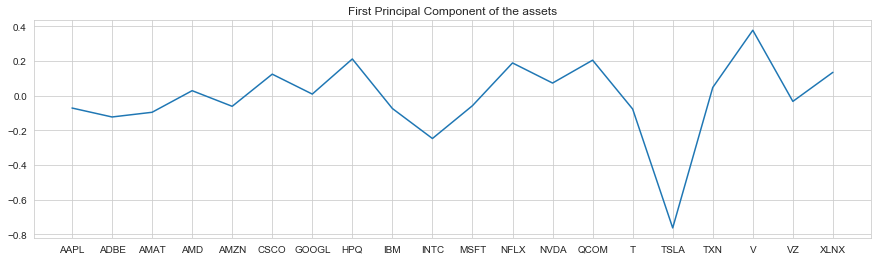

In [22]:
fig, axes = plt.subplots(1)
pc1 = pd.Series(index=index, data=pca.components_[0])
pc1.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='First Principal Component of the assets')
fig.set_size_inches(15, 4) 

In [23]:
pc1.sort_values()

TSLA    -0.762968
INTC    -0.246832
ADBE    -0.122572
AMAT    -0.095433
T       -0.076781
IBM     -0.073665
AAPL    -0.070853
AMZN    -0.060975
MSFT    -0.057339
VZ      -0.032601
GOOGL    0.009582
AMD      0.029239
TXN      0.047799
NVDA     0.073252
CSCO     0.124579
XLNX     0.135229
NFLX     0.189322
QCOM     0.205230
HPQ      0.212300
V        0.378119
dtype: float64

In [24]:
num_assets = len(pca.components_[0])//2
dominant_assets = pc1.sort_values().index[-num_assets:]
dominant_assets = " ".join(dominant_assets)
dominant_assets

'GOOGL AMD TXN NVDA CSCO XLNX NFLX QCOM HPQ V'

## ICA

In [25]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=10,random_state=0).fit(df.transpose().fillna(0))


[*********************100%***********************]  20 of 20 completed


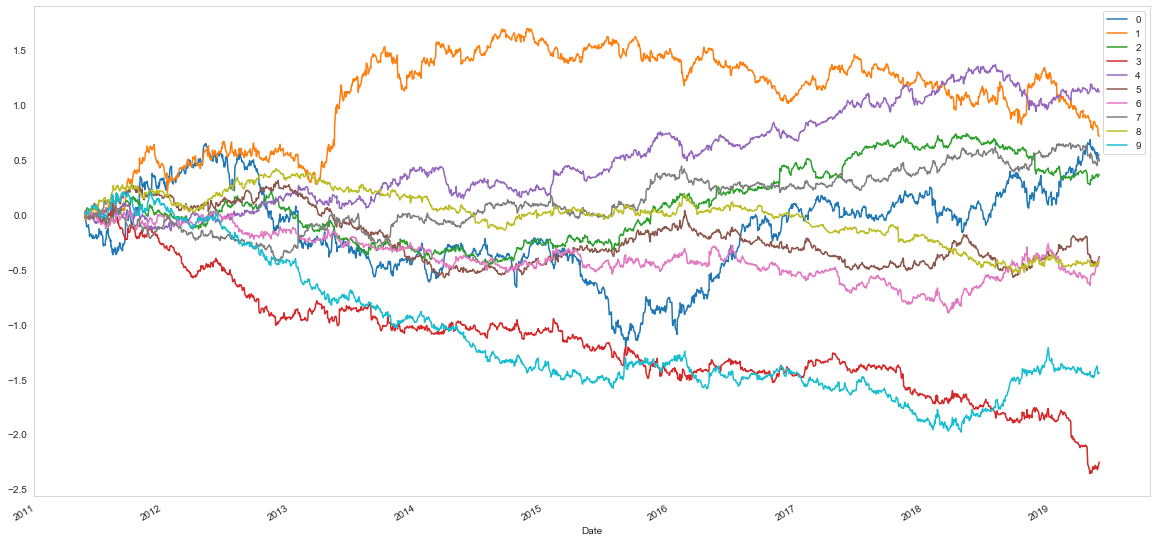

In [26]:
fig, ax = plt.subplots(1, figsize=(20, 10)) 
pan = yf.download(tickers, start="2011-05-20", end="2019-05-21")
ret = pan["Adj Close"].apply(np.log).diff(1)
for i in range(10):
    ret.dot(ica.components_[i]).cumsum().plot(ax=ax)
ax.legend([str(i) for i in range(10)])
ax.grid()

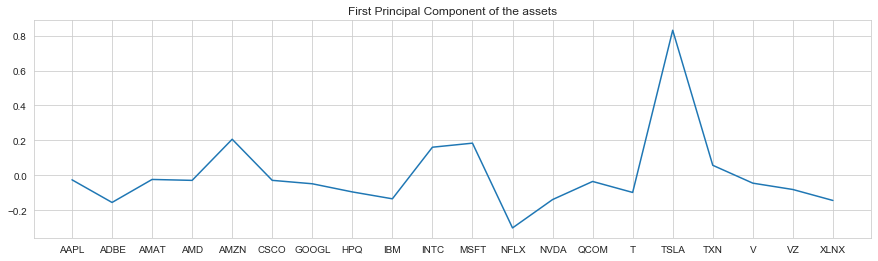

In [27]:
fig, axes = plt.subplots(1)
ic1 = pd.Series(index=index, data=ica.components_[1])
ic1.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='First Principal Component of the assets')
fig.set_size_inches(15, 4) 

In [28]:
ic1.sort_values()

NFLX    -0.300054
ADBE    -0.154449
XLNX    -0.143063
NVDA    -0.137954
IBM     -0.133584
T       -0.097209
HPQ     -0.094203
VZ      -0.080359
GOOGL   -0.047597
V       -0.044078
QCOM    -0.034385
AMD     -0.028172
CSCO    -0.028034
AAPL    -0.024917
AMAT    -0.022891
TXN      0.058093
INTC     0.161453
MSFT     0.184634
AMZN     0.207044
TSLA     0.830346
dtype: float64

In [29]:
num_assets = len(ica.components_[0])//2
dominant_assets_ica = ic1.sort_values().index[-num_assets:]
dominant_assets_ica = " ".join(dominant_assets_ica)
dominant_assets_ica

'QCOM AMD CSCO AAPL AMAT TXN INTC MSFT AMZN TSLA'

# Testing

## PCA

In [30]:
test = yf.download(dominant_assets, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AMD      0.024802
            CSCO     0.009064
            GOOGL    0.008508
            HPQ      0.025001
            NFLX     0.017541
                       ...   
2021-05-19  NVDA     0.003561
            QCOM     0.013484
            TXN      0.015808
            V       -0.004354
            XLNX     0.024732
Length: 5040, dtype: float64

In [31]:
mean_returns = []
for i in range(0,len(returns_test),num_assets):
    mean_returns.append(returns_test[i:i+num_assets].mean())
mean_returns

[0.01902432727165295,
 -0.015147391798610776,
 -0.01937919050384207,
 -0.0006908623135304826,
 0.0038328222570766625,
 -0.010887344675893784,
 0.005600205594054141,
 -0.01868760449991145,
 -0.010629104261704025,
 0.03965746700799992,
 0.0017320059207774018,
 0.013964358269275445,
 0.01350928837246843,
 0.012594740474033861,
 0.0022702919636156337,
 -0.014818873449605885,
 0.0006080783163152859,
 -0.018132547265032883,
 0.00046277835068639914,
 0.031116476662407112,
 0.0036027908234479433,
 0.010537487408423685,
 -0.006723315671011943,
 0.0026229186097843638,
 -0.015868510228200572,
 0.0198693694526058,
 0.010549188146728072,
 -0.0013144496401793937,
 0.01529513223021688,
 -0.0024780758177219476,
 0.004317728885616212,
 -0.0002924764920105183,
 -0.006678694591685863,
 0.007582263361234709,
 0.005442616834090463,
 0.003794449187338911,
 0.00700285618728107,
 0.005899250848970717,
 -0.004247172872330474,
 -0.0035711350336312007,
 -0.008763752909522715,
 -0.008787272390345713,
 0.006873661

In [32]:
df = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

HOOI+PCA


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,26.05%
Cumulative returns,58.886%
Annual volatility,32.458%
Sharpe ratio,0.88
Calmar ratio,0.82
Stability,0.82
Max drawdown,-31.942%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.94,2020-02-19,2020-03-16,2020-07-27,114
1,12.84,2019-07-26,2019-10-08,2019-12-12,100
2,12.50,2020-09-02,2020-09-23,2020-11-06,48
3,10.31,2021-02-12,2021-03-08,2021-04-05,37
4,7.95,2021-04-29,2021-05-12,NaT,NaN


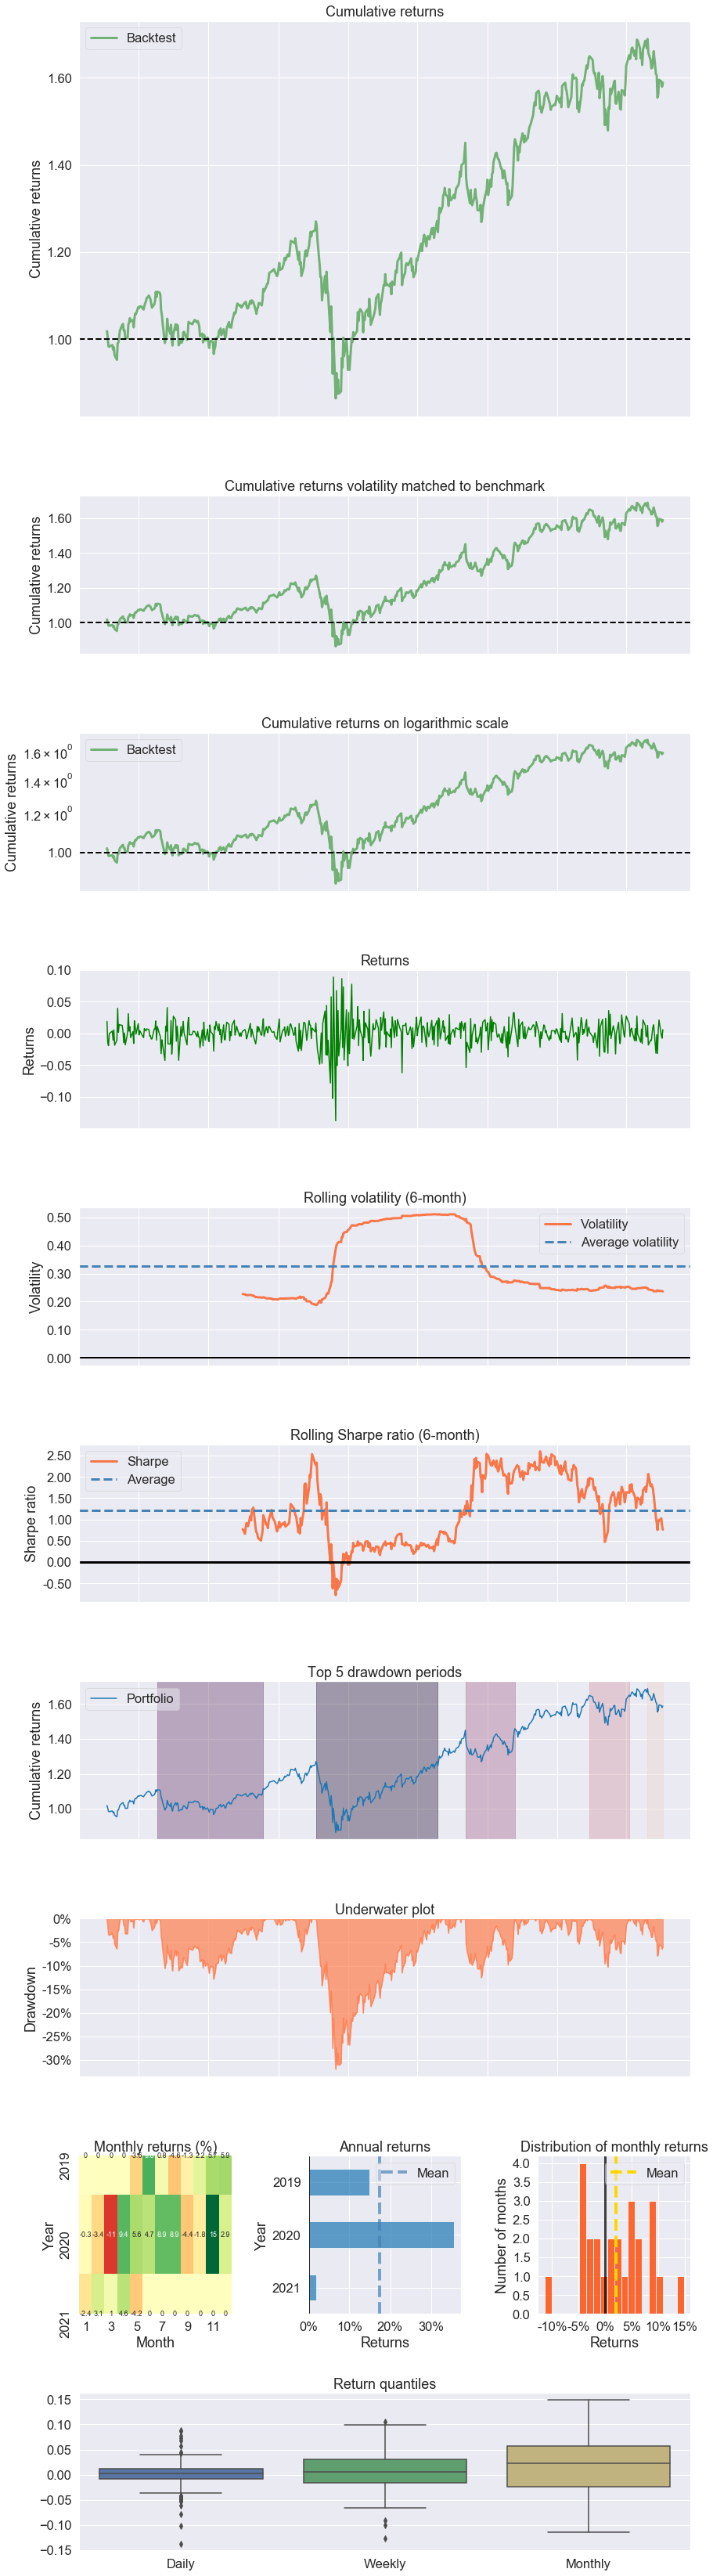

In [33]:
import pyfolio as pf
print("HOOI+PCA")
pf.create_returns_tear_sheet(df)

## ICA

In [34]:
test = yf.download(dominant_assets_ica, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AAPL     0.018989
            AMAT     0.022545
            AMD      0.024802
            AMZN    -0.000780
            CSCO     0.009064
                       ...   
2021-05-19  INTC     0.009437
            MSFT     0.002471
            QCOM     0.013484
            TSLA    -0.025253
            TXN      0.015808
Length: 5040, dtype: float64

In [35]:
mean_returns = []
for i in range(0,len(returns_test),num_assets):
    mean_returns.append(returns_test[i:i+num_assets].mean())
mean_returns

[0.013516277231013651,
 -0.022953176530530993,
 -0.01310617664299123,
 -0.0065888249091342384,
 0.0012539426707099733,
 -0.002617567263049869,
 0.005208985772408958,
 -0.01755224728792677,
 -0.012697867223757875,
 0.03956014775937104,
 0.007383342983380947,
 0.02144172376162512,
 0.015661453919552093,
 0.022128125138040612,
 0.004382572679513119,
 -0.018916667633183604,
 0.004102116910613152,
 -0.013490136058046253,
 0.0017471296822357818,
 0.025121749874406074,
 0.0014385892136751012,
 0.004197798888462589,
 -0.003799172438144982,
 0.002082848884126509,
 -0.016117604611050718,
 0.02028359211547275,
 0.006112123292141547,
 -0.003119490496322541,
 0.015010239038831318,
 -0.0009642584999854265,
 0.00813021144264905,
 -0.002338627724994424,
 -0.0043958933441889505,
 0.0072948310578158536,
 0.011022028155606777,
 -0.0019261994778282166,
 0.01420431179311521,
 0.010358111047478946,
 -0.008138561816791557,
 -0.0027784197034003365,
 0.003696006776074556,
 -0.0027380107026146574,
 0.0154490974

In [36]:
df = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

HOOI+ICA


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,44.217%
Cumulative returns,107.986%
Annual volatility,34.842%
Sharpe ratio,1.23
Calmar ratio,1.26
Stability,0.92
Max drawdown,-35.223%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.22,2020-02-19,2020-03-20,2020-07-06,99
1,13.25,2020-09-02,2020-09-23,2020-11-24,60
2,12.96,2021-02-12,2021-03-08,2021-04-08,40
3,11.54,2019-07-24,2019-08-23,2019-10-25,68
4,10.73,2021-04-09,2021-05-12,NaT,NaN


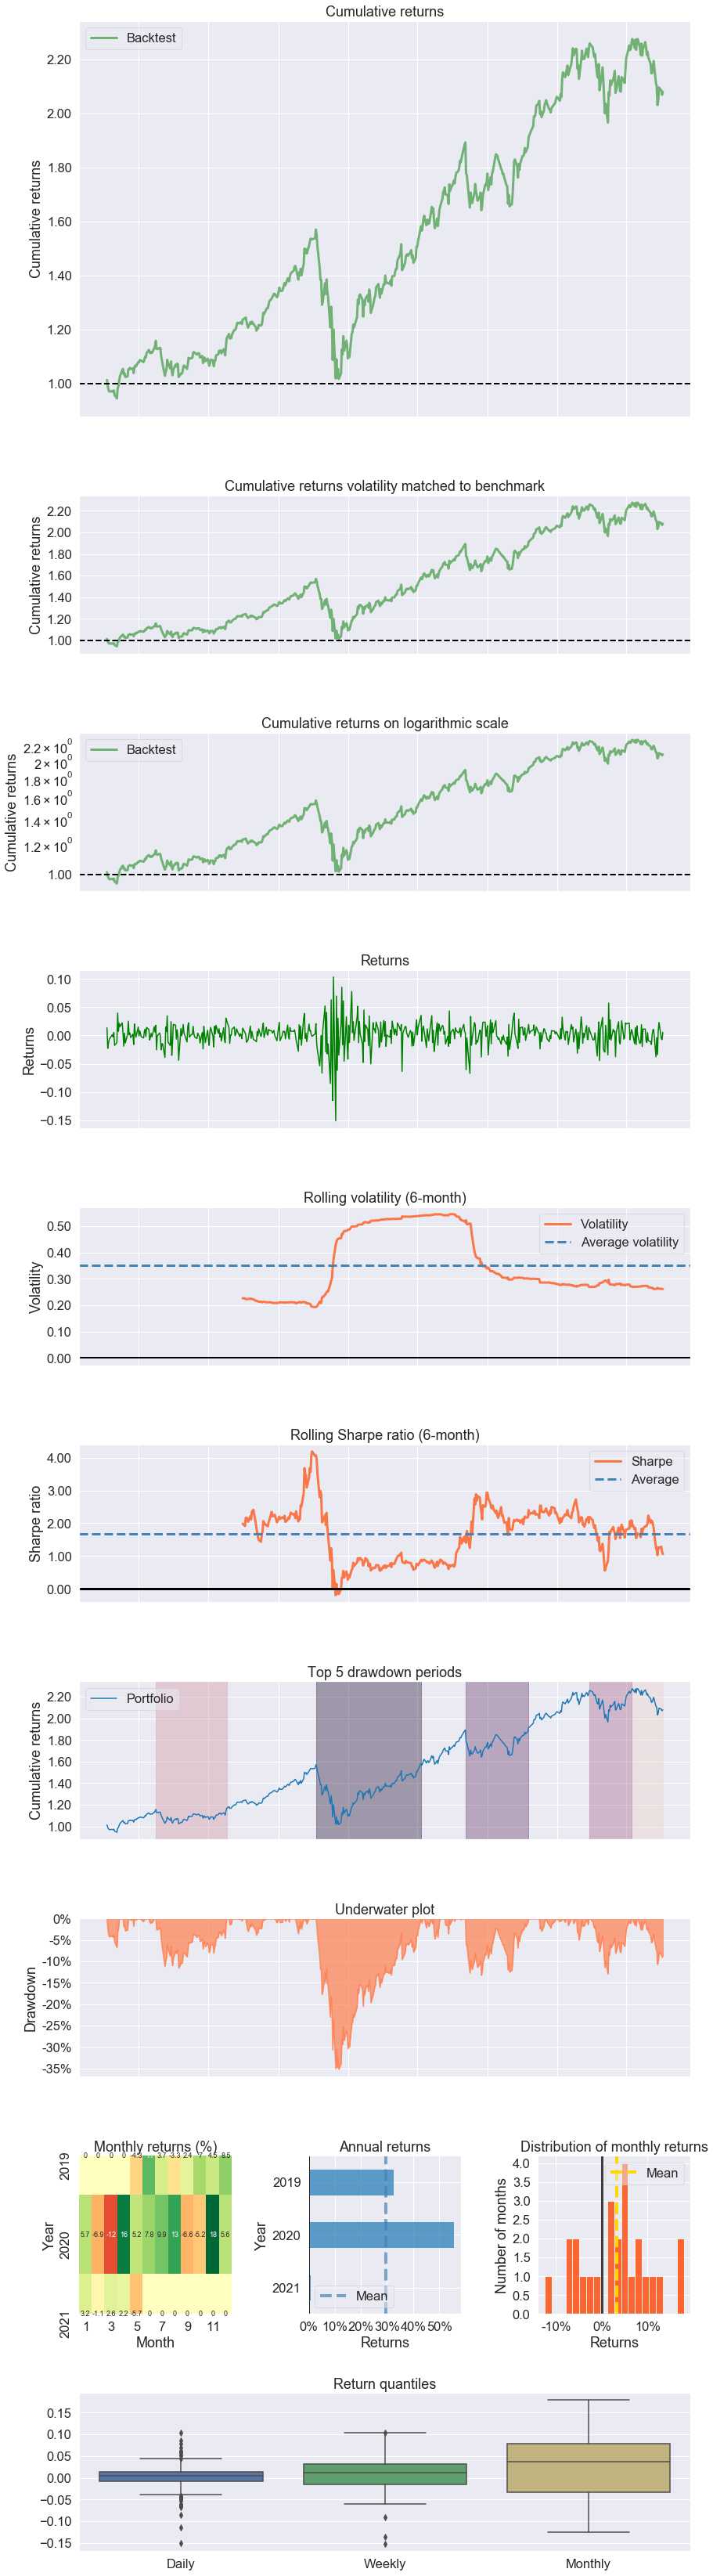

In [37]:
import pyfolio as pf
print("HOOI+ICA")
pf.create_returns_tear_sheet(df)